In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cse493g1/assignments/assignment1/'
FOLDERNAME = 'Colab Notebooks/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [12]:
%load_ext autoreload
%autoreload 2
%pip install positional-encodings[pytorch]
from positional_encodings.torch_encodings import PositionalEncoding1D, Summer
import torch
import model
from torch.utils.data import Dataset, DataLoader

class TransformerDataset(Dataset):
    def __init__(self, data, targets, normalize=True):
        # Move data to CUDA
        data = data.to(CUDA)

        # Positional encoding across *location*: this lib encodes along the last dimension
        summer = Summer(PositionalEncoding1D(ECoG_ELECTRODES)).to(CUDA)
        pre_data = summer(data.unsqueeze(1))

        # Transformer implementation expects (batch, electrode, time) for electrode encoding
        pre_data = pre_data.permute(0, 2, 1)

        # Normalize data and targets if required
        if normalize:
            # Normalize data by the mean and std of the whole dataset
            self.data_mean = pre_data.mean()
            self.data_std = pre_data.std()
            self.data = (pre_data - self.data_mean) / (self.data_std + 1e-6)

            # Compute and store mean and std for targets along the second dimension
            self.target_mean = targets.mean(dim=0, keepdim=True)
            self.target_std = targets.std(dim=0, keepdim=True)
            self.targets = (targets - self.target_mean) / (self.target_std + 1e-6)
            self.targets = targets.to(CUDA)
        else:
            self.data = pre_data.to(CUDA)
            self.targets = targets.to(CUDA)
            self.data_mean = None
            self.data_std = None
            self.target_mean = None
            self.target_std = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def denormalize_targets(self, normalized_targets):
        """Denormalize the targets using stored mean and std."""
        if self.target_mean is not None and self.target_std is not None:
            return normalized_targets * self.target_std + self.target_mean
        else:
            raise ValueError("Targets were not normalized or mean and std were not saved.")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import random

def generateSineWave(start_time, end_time, sample_rate, frequency, amplitude=1, offset=0):
    time = np.arange(start_time, end_time, 1/sample_rate)
    return amplitude * np.sin(2 * np.pi * frequency * time + offset)
st = 0     # start time
et = 60    # end time
sr = 1000  # sampling rate
num_ch_ecog = 129
synth_ecog = generateSineWave(st, et, sr, 10) + generateSineWave(st, et, sr, 5) + generateSineWave(st, et, sr, 3)
for i in range(num_ch_ecog-1):
    synth_ecog = np.vstack((synth_ecog, generateSineWave(st, et, sr, random.randint(1,44), random.randint(1,3)) + generateSineWave(st, et, sr, random.randint(1,44), random.randint(1,3)) + generateSineWave(st, et, sr, random.randint(1,44), random.randint(1,3))))

num_ch_eeg = 19
synth_eeg = generateSineWave(st, et, sr, 6) + generateSineWave(st, et, sr, 2)
for i in range(num_ch_eeg-1):
    synth_eeg = np.vstack((synth_eeg, generateSineWave(st, et, sr, random.randint(1,44), random.randint(1,3)) + generateSineWave(st, et, sr, random.randint(1,44), random.randint(1,3))))

print(synth_ecog.shape)
print(synth_eeg.shape)

(129, 60000)
(19, 60000)


In [10]:
from sklearn.model_selection import train_test_split

X = torch.tensor(synth_ecog.T, dtype=torch.float)
y = torch.tensor(synth_eeg.T, dtype=torch.float)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.9, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.8, shuffle=False)

In [13]:
BATCH_SIZE = 100
EPOCH_LEN = 1   # In "time steps"
ECoG_ELECTRODES = X.size(1)
EEG_ELECTRODES = y.size(1)
CUDA = "cuda"

train_dataset = TransformerDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
val_dataset = TransformerDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataset = TransformerDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# NOTE: num_heads must divide input_size!
num_heads = 1
num_layers = 4

In [14]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import copy

# Training and evaluation function
def train_and_evaluate(xformer, optim, train_loader, val_loader, num_epochs):
    criterion = torch.nn.MSELoss()
    train_losses = []
    val_losses = []

    best_val_loss = float('inf')
    best_model = None

    for epoch in range(num_epochs):
        # Training loop
        xformer.train()
        total_train_loss = 0.0
        for data, targets in train_loader:
            data, targets = data.to(CUDA), targets.to(CUDA)
            optim.zero_grad()
            outputs = xformer(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optim.step()
            total_train_loss += loss.item() * data.size(0)

        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation loop
        xformer.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(CUDA), targets.to(CUDA)
                outputs = xformer(data)
                loss = criterion(outputs, targets)
                total_val_loss += loss.item() * data.size(0)

        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = copy.deepcopy(xformer.state_dict())

    return best_model, train_losses, val_losses

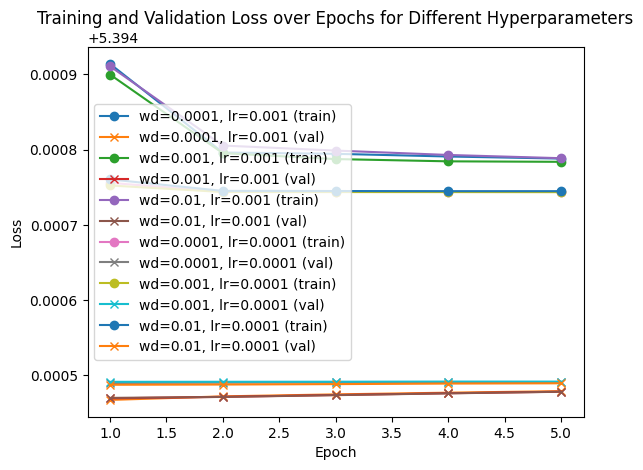

In [16]:
# Define the hyperparameter grid
learning_rates = [0.001, 0.0001]
weight_decays = [0.0001, 0.001, 0.01]
num_initial_epochs = 5

# Initialize a dictionary to store results
results = {}

# Hyperparameter tuning loop
best_model_params = None
best_val_loss = float('inf')
best_lr = None
best_wd = None

for lr in learning_rates:
    for wd in weight_decays:
        xformer, optim = model.get_transformer(
            input_size=EPOCH_LEN,
            num_layers=num_layers,
            num_heads=num_heads,
            n_embd=EPOCH_LEN,
            out_dim=EEG_ELECTRODES,
            trial_len=ECoG_ELECTRODES,
            cuda=CUDA,
            weight_decay=wd,
            learning_rate=lr
        )

        best_model, train_losses, val_losses = train_and_evaluate(xformer, optim, train_loader, val_loader, num_initial_epochs)
        results[(wd, lr)] = (train_losses, val_losses)

        if val_losses[-1] < best_val_loss:
            best_val_loss = val_losses[-1]
            best_model_params = best_model
            best_lr = lr
            best_wd = wd

# Save the best model
torch.save(best_model_params, '/content/drive/MyDrive/Colab Notebooks/sythestic/best_model.pth')

# Plot the loss curves for each combination
for (weight_decay, learning_rate), (train_losses, val_losses) in results.items():
    plt.plot(range(1, num_initial_epochs + 1), train_losses, marker='o', label=f'wd={weight_decay}, lr={learning_rate} (train)')
    plt.plot(range(1, num_initial_epochs + 1), val_losses, marker='x', label=f'wd={weight_decay}, lr={learning_rate} (val)')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs for Different Hyperparameters')
plt.legend()
plt.show()

Epoch 1/20, Train Loss: 5.3949214537938435, Test Loss: 5.394840413773501
Epoch 2/20, Train Loss: 5.3948126316070555, Test Loss: 5.394828447589168
Epoch 3/20, Train Loss: 5.394804676373799, Test Loss: 5.394821742066631
Epoch 4/20, Train Loss: 5.394798429807027, Test Loss: 5.39481727834101
Epoch 5/20, Train Loss: 5.3947933991750086, Test Loss: 5.3948139625566975
Epoch 6/20, Train Loss: 5.39478976726532, Test Loss: 5.394811304631056
Epoch 7/20, Train Loss: 5.394787255922953, Test Loss: 5.394809267035237
Epoch 8/20, Train Loss: 5.394785801569621, Test Loss: 5.394807726144791
Epoch 9/20, Train Loss: 5.39478501478831, Test Loss: 5.394806137791386
Epoch 10/20, Train Loss: 5.394784569740295, Test Loss: 5.39480486732942
Epoch 11/20, Train Loss: 5.39478440284729, Test Loss: 5.394803995335543
Epoch 12/20, Train Loss: 5.394784132639567, Test Loss: 5.394803278976017
Epoch 13/20, Train Loss: 5.394783981641134, Test Loss: 5.394802471001943
Epoch 14/20, Train Loss: 5.394783886273702, Test Loss: 5.3948

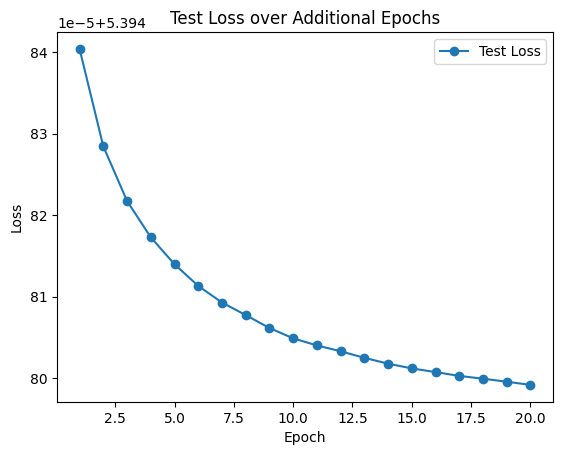

In [17]:
# Load the best model and optimizer
xformer, optim = model.get_transformer(
    input_size=EPOCH_LEN,
    num_layers=num_layers,
    num_heads=num_heads,
    n_embd=EPOCH_LEN,
    out_dim=EEG_ELECTRODES,
    trial_len=ECoG_ELECTRODES,
    cuda=CUDA,
    weight_decay=best_wd,
    learning_rate=best_lr
)
xformer.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/sythestic/best_model.pth'))

# Continue training the best model and evaluate on the test set
test_losses = []
criterion = torch.nn.MSELoss()
num_additional_epochs = 20

for epoch in range(num_additional_epochs):
    # Training loop
    xformer.train()
    total_train_loss = 0.0
    for data, targets in train_loader:
        data, targets = data.to(CUDA), targets.to(CUDA)
        optim.zero_grad()
        outputs = xformer(data)
        loss = criterion(outputs, targets)
        loss.backward()
        optim.step()
        total_train_loss += loss.item() * data.size(0)

    avg_train_loss = total_train_loss / len(train_loader.dataset)

    # Evaluation on the test set
    xformer.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(CUDA), targets.to(CUDA)
            outputs = xformer(data)
            loss = criterion(outputs, targets)
            total_test_loss += loss.item() * data.size(0)

    avg_test_loss = total_test_loss / len(test_loader.dataset)
    test_losses.append(avg_test_loss)

    print(f'Epoch {epoch+1}/{num_additional_epochs}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}')

# Plot the test loss curve
plt.plot(range(1, num_additional_epochs + 1), test_losses, marker='o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss over Additional Epochs')
plt.legend()
plt.show()